# The KoLeo loss

The KoLeo loss is a regularizer that pushes representations to spread uniformly in their space by maximizing their minimum distance from each other.

## Where does the KoLeo loss come from?

The KoLeo loss was introduced in this [paper](https://arxiv.org/pdf/1806.03198). It is a loss function derived from the Kozachenko–Leonenko estimator. It allows approximating Shannon entropy using distances to the k nearest neighbors. If you want to learn more about this estimator, I recommend visiting this [page](https://infomeasure.readthedocs.io/en/stable/guide/entropy/kozachenko_leonenko/).

The DINO family of self-supervised learning models has implemented this loss which you can find [here](https://github.com/facebookresearch/dinov2/blob/main/dinov2/loss/koleo_loss.py).

One of the key benefits of this loss is preventing *collapse*. Model collapse refers to a failure mode in self-supervised learning where the model learns to map all inputs to the same (or very similar) embedding vector. When collapse occurs, all the learned features are indistinguishable and the model loses its ability to represent meaningful differences between examples, effectively destroying the utility of the learned representations. The KoLeo loss mitigates this by encouraging the embeddings to spread out in the representation space, helping the model avoid this degenerate solution.

We will therefore try to integrate the KoLeo loss into our training code and observe the results on our Siamese network. Will we observe, as expected, a greater spread of embeddings?

## Integrating the KoLeo loss into the code

First, let's take the KoLeo loss implementation from DINOv2.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class KoLeoLoss(nn.Module):
    """Kozachenko-Leonenko entropic loss regularizer from Sablayrolles et al. - 2018 - Spreading vectors for similarity search"""

    def __init__(self):
        super().__init__()
        self.pdist = nn.PairwiseDistance(2, eps=1e-8)

    def pairwise_NNs_inner(self, x):
        """
        Pairwise nearest neighbors for L2-normalized vectors.
        Uses Torch rather than Faiss to remain on GPU.
        """
        # parwise dot products (= inverse distance)
        dots = torch.mm(x, x.t())
        n = x.shape[0]
        dots.view(-1)[:: (n + 1)].fill_(-1)  # Trick to fill diagonal with -1
        _, indices = torch.max(dots, dim=1)  # max inner prod -> min distance
        return indices

    def forward(self, student_output, eps=1e-8):
        """
        Args:
            student_output (BxD): backbone output of student
        """
        with torch.autocast("cuda", enabled=False):
            student_output = F.normalize(student_output, eps=eps, p=2, dim=-1)
            indices = self.pairwise_NNs_inner(student_output)
            distances = self.pdist(student_output, student_output[indices])  # BxD, BxD -> B
            loss = -torch.log(distances + eps).mean()
        return loss


In [2]:
import sys
sys.path.append("../..")

from training_utils import (
    get_device, load_cifar10, build_triplets,
    create_dataloaders, VGG11Embedding, triplet_loss,
    setup_training_dir, log_metrics, plot_losses, 
    construct_embeddings_by_class, 
    VAL_TRANSFORMS, LABEL_NAMES
)


As in part 1, we start by defining the seed and building our triplets.


In [5]:
import numpy as np

seed = 42
device = get_device()
print(f"Device: {device}")

images, labels = load_cifar10("../../../cifar-10-python")
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

np.random.seed(seed)
triplets, triplets_labels = build_triplets(images, labels, n_neg=2500)
print(f"Triplets shape: {triplets.shape}")


Device: mps
Images shape: (50000, 32, 32, 3), Labels shape: (50000,)
Triplets shape: (25000, 3, 32, 32, 3)


Here we add the `koleo_weight` variable, a new hyperparameter.


In [6]:
from torchvision.models import VGG11_Weights
from torch.utils.data import DataLoader
from training_utils import TripletsCIFAR10Dataset, TRAIN_TRANSFORMS, VAL_TRANSFORMS

batch_size = 64
learning_rate = 5e-4
margin = 0.4
koleo_weight = None
val_split = 0.05

num_train = int((1 - val_split) * len(triplets))

np.random.seed(seed)
shuffle_indices = np.random.permutation(len(triplets))
shuffled_triplets = triplets[shuffle_indices]
shuffled_triplets_labels = triplets_labels[shuffle_indices]

train_triplets = shuffled_triplets[:num_train, ...]
val_triplets = shuffled_triplets[num_train:]
train_labels = shuffled_triplets_labels[:num_train, ...]
val_labels = shuffled_triplets_labels[num_train:]

train_dataset = TripletsCIFAR10Dataset(train_triplets, transform=TRAIN_TRANSFORMS)
val_dataset = TripletsCIFAR10Dataset(val_triplets, transform=VAL_TRANSFORMS)

net = VGG11Embedding(weights=VGG11_Weights.IMAGENET1K_V1).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

koleo_loss_fn = KoLeoLoss()

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

print(shuffle_indices)


Train: 23750, Val: 1250
[ 6868 24016  9668 ...   860 15795 23654]


And we rewrite our training loop by inserting the KoLeo loss into the loss calculation.


In [18]:
from sklearn.metrics import roc_auc_score

def train_loop(net, dataloader, optimizer, margin, koleo_weight, print_freq=100):
    net.train()
    loss_accum = 0.0
    epoch_loss = 0.0
    for batch_idx, (anc, pos, neg) in enumerate(dataloader):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
        anc_feat, pos_feat, neg_feat = net(anc), net(pos), net(neg)

        t_loss = triplet_loss(anc_feat, pos_feat, neg_feat, margin)
        all_embeddings = torch.cat([anc_feat, pos_feat, neg_feat], dim=0)
        k_loss = koleo_loss_fn(all_embeddings)
        if koleo_weight is not None:
            loss = t_loss + koleo_weight * k_loss
        else:
            loss = t_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_accum += loss.item()
        epoch_loss += loss.item()

        if (batch_idx + 1) % print_freq == 0:
            print(f"Batch {batch_idx+1}: Loss = {loss_accum / print_freq:.4f}")
            loss_accum = 0.0

    return epoch_loss / (batch_idx + 1)

def validation_loop(net, dataloader, margin, koleo_weight, device):
    net.eval()
    val_loss = 0
    good_triplets = 0
    total_triplets = 0

    positive_similarities = []
    negative_similarities = []
    
    positive_euclidean_distances = []
    negative_euclidean_distances = []

    with torch.no_grad():
        for batch_idx, (anc, pos, neg) in enumerate(dataloader):
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
            anc_feat, pos_feat, neg_feat = net(anc), net(pos), net(neg)
            
            loss = triplet_loss(anc_feat, pos_feat, neg_feat, margin)
            if koleo_weight is not None:
                loss += koleo_weight * koleo_loss_fn(torch.cat([anc_feat, pos_feat, neg_feat], dim=0))

            val_loss += loss.item()

            batch_positive_euclidean_distances = F.pairwise_distance(anc_feat, pos_feat, p=2)
            batch_negative_euclidean_distances = F.pairwise_distance(anc_feat, neg_feat, p=2)
            positive_euclidean_distances.append(batch_positive_euclidean_distances)
            negative_euclidean_distances.append(batch_negative_euclidean_distances)

            batch_positive_similarities = F.cosine_similarity(anc_feat, pos_feat, dim=1)
            batch_negative_similarities = F.cosine_similarity(anc_feat, neg_feat, dim=1)
            positive_similarities.append(batch_positive_similarities)
            negative_similarities.append(batch_negative_similarities)

            good_triplets += (batch_positive_similarities > batch_negative_similarities).sum()
            total_triplets += anc.shape[0]

        positive_euclidean_distances = torch.cat(positive_euclidean_distances, dim=0)
        negative_euclidean_distances = torch.cat(negative_euclidean_distances, dim=0)

        positive_similarities = torch.cat(positive_similarities, dim=0)
        negative_similarities = torch.cat(negative_similarities, dim=0)

        predict_similarities = torch.cat([positive_similarities, negative_similarities], dim=0)
        target_similarities = torch.cat([torch.ones_like(positive_similarities), torch.zeros_like(negative_similarities)], dim=0)

        val_auc = roc_auc_score(target_similarities.detach().cpu().numpy(), predict_similarities.detach().cpu().numpy())
        mean_positive_similarities = predict_similarities[:len(predict_similarities)//2].mean().item()
        mean_negative_similarities = predict_similarities[len(predict_similarities)//2:].mean().item()
        mean_positive_euclidean_distances = positive_euclidean_distances.mean().item()
        mean_negative_euclidean_distances = negative_euclidean_distances.mean().item()
        good_triplets_ratio = (good_triplets / total_triplets).item()
    
    return {
        'val_loss': val_loss / (batch_idx + 1),
        'val_auc': val_auc,
        'mean_positive_similarities': mean_positive_similarities,
        'mean_negative_similarities': mean_negative_similarities,
        'mean_positive_euclidean_distances': mean_positive_euclidean_distances,
        'mean_negative_euclidean_distances': mean_negative_euclidean_distances,
        'good_triplets_ratio': good_triplets_ratio
    }


We then configure our directory where runs will be stored before training.


In [19]:
epochs = 15

config = {
    "seed": seed, "batch_size": batch_size, "learning_rate": learning_rate,
    "epochs": epochs, "margin": margin, "koleo_weight": koleo_weight, "val_split": val_split
}
save_dir, metrics_path, csv_headers = setup_training_dir("runs_koleo", config)


We can launch the training!


In [21]:
import random

train_losses = []
val_losses = []
best_auc = 0
best_epoch_path = None

random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
if torch.mps.is_available():
    torch.mps.manual_seed(seed)

gt = torch.Generator()
gt.manual_seed(seed)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gt)

net = VGG11Embedding(weights=VGG11_Weights.IMAGENET1K_V1).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

val_metrics = validation_loop(net, val_loader, margin, koleo_weight, device)
print(f"Before training, epoch 0 — val_loss = {val_metrics['val_loss']}")
print(f"Before training - val_loss: {val_metrics['val_loss']:.4f}, val_auc: {val_metrics['val_auc']:.4f}")
log_metrics(metrics_path, csv_headers, 0, "", val_metrics)

for epoch_idx in range(epochs):
    train_loss = train_loop(net, train_loader, optimizer, margin, koleo_weight)
    val_metrics = validation_loop(net, val_loader, margin, koleo_weight, device)
    val_losses.append(val_metrics['val_loss'])
    train_losses.append(train_loss)
    
    print(f"Epoch {epoch_idx+1} - train_loss: {train_loss:.4f}, val_loss: {val_metrics['val_loss']:.4f}, val_auc: {val_metrics['val_auc']:.4f}")
    log_metrics(metrics_path, csv_headers, epoch_idx + 1, train_loss, val_metrics)

    if val_metrics['val_auc'] > best_auc:
        best_auc = val_metrics['val_auc']
        if best_epoch_path is not None:
            best_epoch_path.unlink()
        best_epoch_path = save_dir / f'best_epoch_{epoch_idx+1}.pth'
        torch.save(net.state_dict(), best_epoch_path)
        print(f"New best AUC: {best_auc:.4f} at epoch {epoch_idx+1}")


Before training, epoch 0 — val_loss = 0.3155814856290817
Before training - val_loss: 0.3156, val_auc: 0.6642
Batch 100: Loss = 0.2465
Batch 200: Loss = 0.2036
Batch 300: Loss = 0.1619
Epoch 1 - train_loss: 0.1966, val_loss: 0.1742, val_auc: 0.8233
New best AUC: 0.8233 at epoch 1
Batch 100: Loss = 0.1609
Batch 200: Loss = 0.1348
Batch 300: Loss = 0.1436
Epoch 2 - train_loss: 0.1433, val_loss: 0.1177, val_auc: 0.8939
New best AUC: 0.8939 at epoch 2
Batch 100: Loss = 0.1226
Batch 200: Loss = 0.1147
Batch 300: Loss = 0.1107
Epoch 3 - train_loss: 0.1162, val_loss: 0.1216, val_auc: 0.8894
Batch 100: Loss = 0.1035
Batch 200: Loss = 0.1001
Batch 300: Loss = 0.0952
Epoch 4 - train_loss: 0.0992, val_loss: 0.1136, val_auc: 0.8990
New best AUC: 0.8990 at epoch 4
Batch 100: Loss = 0.0947
Batch 200: Loss = 0.0880
Batch 300: Loss = 0.0857
Epoch 5 - train_loss: 0.0879, val_loss: 0.0829, val_auc: 0.9301
New best AUC: 0.9301 at epoch 5
Batch 100: Loss = 0.0810
Batch 200: Loss = 0.0743
Batch 300: Loss = 

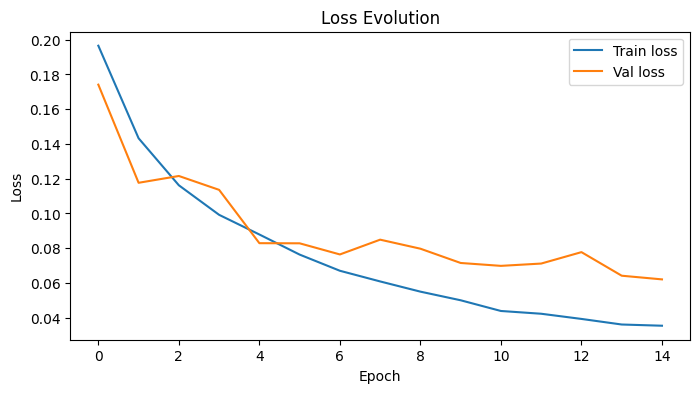

In [22]:
plot_losses(train_losses, val_losses, title="Loss Evolution")

In [21]:
from pathlib import Path

# save_dir = Path("runs_koleo/20251214_130348")
# net.load_state_dict(torch.load(save_dir / 'best_epoch_2.pth'))


## Training Results

### Distance Matrix
Let's now visualize the distance matrix of embeddings and compare it to the distance matrix obtained in chapter 1. As with the training_utils.py file, I also created the plot_utils.py file.


Distance matrix heatmap saved at runs_koleo/20251226_192832/distance_matrix_heatmap.png


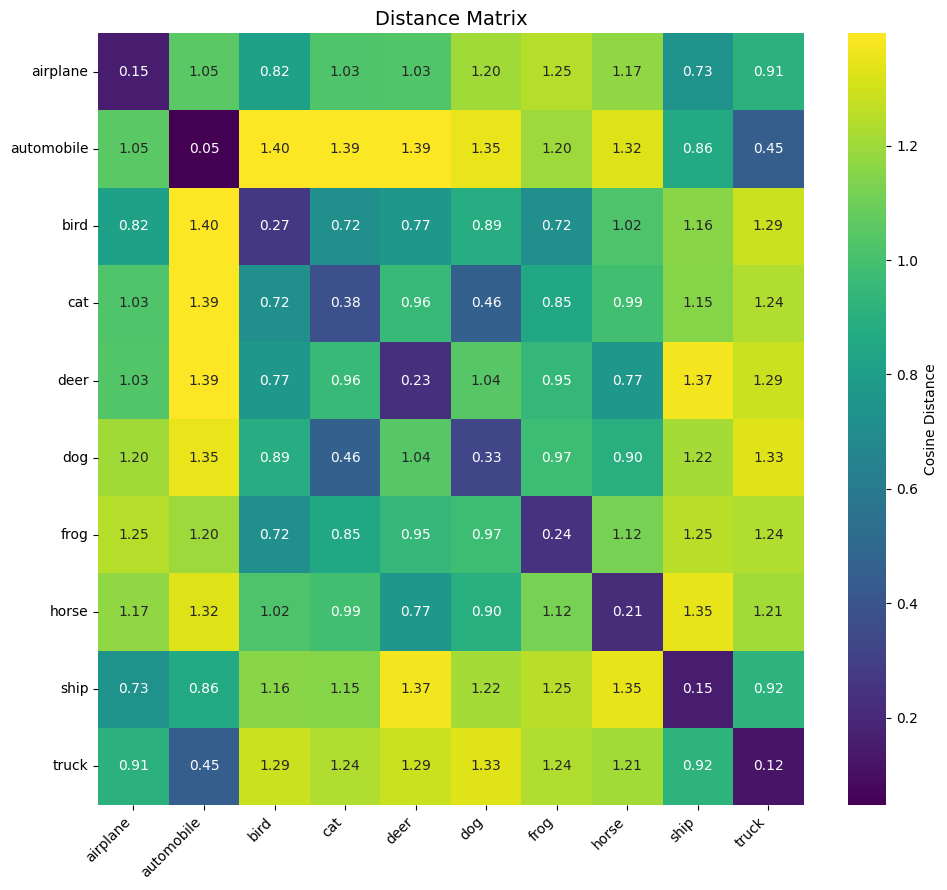


Same-class distances: mean=0.2129, std=0.0946
Different-class distances: mean=1.0596, std=0.2417
Separation margin: 0.8468


In [23]:
from plot_utils import compute_distance_matrix, plot_distance_matrix_heatmap

embeddings_by_class = construct_embeddings_by_class(net, val_labels, val_triplets, VAL_TRANSFORMS, device)
dist_matrix = compute_distance_matrix(embeddings_by_class)
plot_distance_matrix_heatmap(dist_matrix, LABEL_NAMES, save_dir / "distance_matrix_heatmap.png")


Let's display the matrix obtained without the KoLeo loss.

![Distance matrix with simple triplet loss](../../runs/20251213_224845/distance_matrix_heatmap.png)


We can already observe that the distance values in the diagonals are lower when the model was trained with the simple triplet loss. This seems to indicate that the data is more spread out in their space.

Let's see what this looks like on a plane using PCA. We'll display the normalized version right away to compare with the previous projection.


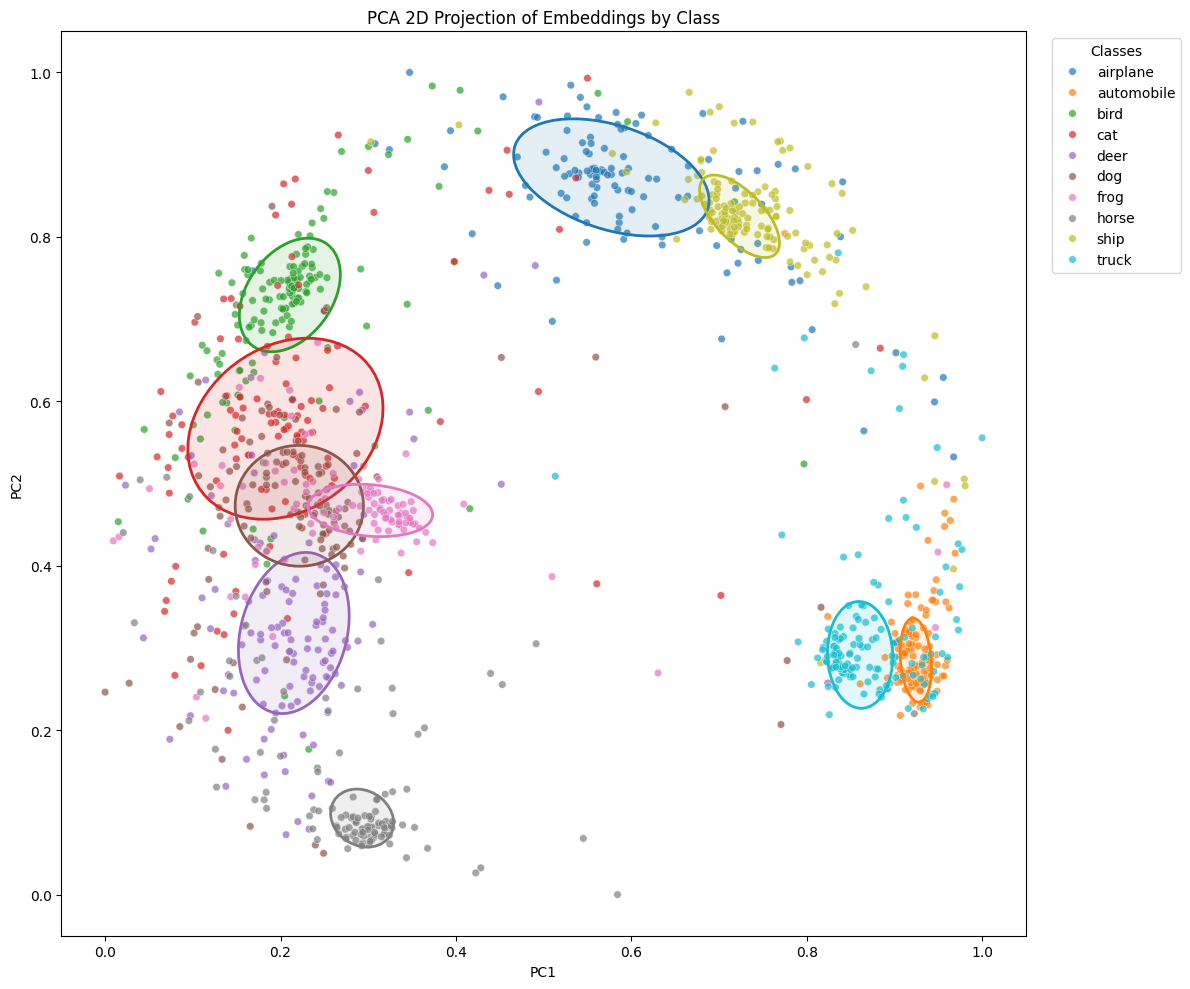

In [24]:
import numpy as np
from sklearn.decomposition import PCA

from plot_utils import get_ellipse_params_per_class, plot_embeddings_with_ellipses

all_embeddings = torch.cat([embeddings_by_class[k] for k in embeddings_by_class], dim=0)

pca_2d = PCA(n_components=2)
embeddings_2d = pca_2d.fit_transform(all_embeddings)
embeddings_2d = (embeddings_2d - embeddings_2d.min(axis=0)) / (embeddings_2d.max(axis=0) - embeddings_2d.min(axis=0))
samples_per_class = [len(embeddings_by_class[i]) for i in range(10)]

labels_array = np.concatenate([np.full(count, label) for label, count in enumerate(samples_per_class)])
ellipse_params = get_ellipse_params_per_class(embeddings_2d, labels_array, LABEL_NAMES, coverage=0.5)
plot_embeddings_with_ellipses(
    embeddings_2d,
    ellipse_params,
    labels_array,
    LABEL_NAMES,
    save_img_path = save_dir / "embeddings_2d_normalized.png",
)


Let's recall the projection without the KoLeo loss

![PCA projection with simple triplet loss](runs/20251213_224845/embeddings_2d_normalized.png)


### Observations on the projections

The two PCA projections (with and without KoLeo loss) show notable differences. We observe that the KoLeo loss seems to indeed spread the embeddings more in space. The ellipses appear globally larger, which is consistent with the regularization objective: maximizing the minimum distance between representations.

To quantify this observation, let's calculate the areas of the ellipses for a few representative classes.


In [ ]:
for k, v in ellipse_params.items():
    area = np.pi * v["width"] * v["height"]
    v["area"] = area

print("Ellipse areas (with KoLeo loss):")
for k in ["cat", "dog", "horse", "ship"]:
    print(f"  Area of {k}'s ellipse = {ellipse_params[k]['area']:.6f}")


Let's compare these values with those obtained without the KoLeo loss:

| Class | Without KoLeo | With KoLeo |
|-------|---------------|------------|
| cat   | 0.131         | 0.167      |
| dog   | 0.029         | 0.095      |
| horse | 0.019         | 0.201      |
| ship  | 0.007         | 0.268      |

Results vary from one run to another depending on the seed and train/validation split. To have a more robust and statistically significant comparison, we will use cross-validation (k-fold cross-validation).


### K-Fold Implementation

We will use `KFold` from scikit-learn to divide our triplets into K=5 folds. For each fold, we will train two models: one with triplet loss alone, and one with triplet loss + KoLeo loss. We will then collect the ellipse areas for each class.


In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from training_utils import TripletsCIFAR10Dataset, TRAIN_TRANSFORMS
import copy

K_FOLDS = 5
EPOCHS_PER_FOLD = 10

kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=seed)

results_no_koleo = {"areas": {cls: [] for cls in LABEL_NAMES}, "auc": []}
results_with_koleo = {"areas": {cls: [] for cls in LABEL_NAMES}, "auc": []}


We define a function that trains a model and returns the ellipse areas. We will also ensure that the training loader always returns the same data for both trainings by initializing the seed just before the training loop.


In [ ]:
def train_and_compute_metrics(train_triplets, train_labels, val_triplets, val_labels, use_koleo, epochs=2):
    train_dataset = TripletsCIFAR10Dataset(train_triplets, transform=TRAIN_TRANSFORMS)
    val_dataset = TripletsCIFAR10Dataset(val_triplets, transform=VAL_TRANSFORMS)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = VGG11Embedding(pretrained=True).to(device)
    optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    kw = koleo_weight if use_koleo else 0.0
    
    best_auc = 0.0
    best_model_state = None
    
    torch.manual_seed(seed)
    for epoch in range(epochs):
        model.train()
        for anc, pos, neg in train_loader:
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
            anc_feat, pos_feat, neg_feat = model(anc), model(pos), model(neg)
            
            loss = triplet_loss(anc_feat, pos_feat, neg_feat, margin)
            if use_koleo:
                all_emb = torch.cat([anc_feat, pos_feat, neg_feat], dim=0)
                loss += kw * koleo_loss_fn(all_emb)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
        
        val_metrics = validation_loop(model, val_loader, margin, kw if use_koleo else None, device)
        current_auc = val_metrics['val_auc']
        
        if current_auc > best_auc:
            best_auc = current_auc
            best_model_state = copy.deepcopy(model.state_dict())
    
    model.load_state_dict(best_model_state)
    
    embeddings_by_class = construct_embeddings_by_class(model, val_labels, val_triplets, VAL_TRANSFORMS, device)
    all_emb = torch.cat([embeddings_by_class[k] for k in embeddings_by_class], dim=0)
    
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(all_emb)
    emb_2d = (emb_2d - emb_2d.min(axis=0)) / (emb_2d.max(axis=0) - emb_2d.min(axis=0))
    
    samples = [len(embeddings_by_class[i]) for i in range(10)]
    lab_arr = np.concatenate([np.full(c, l) for l, c in enumerate(samples)])
    
    ellipse_p = get_ellipse_params_per_class(emb_2d, lab_arr, LABEL_NAMES, coverage=0.5)
    
    areas = {}
    for cls in LABEL_NAMES:
        areas[cls] = np.pi * ellipse_p[cls]["width"] * ellipse_p[cls]["height"]
    
    return {"areas": areas, "auc": best_auc}


Let's now launch the cross-validation. Note: this cell may take several minutes to execute (K folds × 2 models × epochs).


In [ ]:
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(triplets)):
    print(f"\n{'='*50}")
    print(f"Fold {fold_idx + 1}/{K_FOLDS}")
    print(f"{'='*50}")
    
    fold_train_triplets = triplets[train_idx]
    fold_val_triplets = triplets[val_idx]
    fold_train_labels = triplets_labels[train_idx]
    fold_val_labels = triplets_labels[val_idx]
    
    print(f"Training WITHOUT KoLeo loss...")
    metrics_no_koleo = train_and_compute_metrics(
        fold_train_triplets, fold_train_labels, 
        fold_val_triplets, fold_val_labels, 
        use_koleo=False, epochs=EPOCHS_PER_FOLD
    )
    for cls in LABEL_NAMES:
        results_no_koleo["areas"][cls].append(metrics_no_koleo["areas"][cls])
    results_no_koleo["auc"].append(metrics_no_koleo["auc"])
    print(f"  Best AUC: {metrics_no_koleo['auc']:.4f}")
    
    print(f"Training WITH KoLeo loss...")
    metrics_with_koleo = train_and_compute_metrics(
        fold_train_triplets, fold_train_labels, 
        fold_val_triplets, fold_val_labels, 
        use_koleo=True, epochs=EPOCHS_PER_FOLD
    )
    for cls in LABEL_NAMES:
        results_with_koleo["areas"][cls].append(metrics_with_koleo["areas"][cls])
    results_with_koleo["auc"].append(metrics_with_koleo["auc"])
    print(f"  Best AUC: {metrics_with_koleo['auc']:.4f}")
    
    print(f"Fold {fold_idx + 1} done.")


In [ ]:
auc_no_koleo = np.array(results_no_koleo["auc"])
auc_with_koleo = np.array(results_with_koleo["auc"])

print("=" * 70)
print("AUC SCORES")
print("=" * 70)
print(f"Without KoLeo: {auc_no_koleo.mean():.4f} +/- {auc_no_koleo.std():.4f}")
print(f"With KoLeo: {auc_with_koleo.mean():.4f} +/- {auc_with_koleo.std():.4f}")

print("\n" + "=" * 70)
print("ELLIPSE AREAS")
print("=" * 70)
print(f"{'Class':<12} | {'Without KoLeo (mean +/- std)':<25} | {'With KoLeo (mean +/- std)':<25}")
print("-" * 70)

for cls in ["cat", "dog", "horse", "ship"]:
    no_koleo_arr = np.array(results_no_koleo["areas"][cls])
    with_koleo_arr = np.array(results_with_koleo["areas"][cls])
    
    print(f"{cls:<12} | {no_koleo_arr.mean():.4f} +/- {no_koleo_arr.std():.4f}        | {with_koleo_arr.mean():.4f} +/- {with_koleo_arr.std():.4f}")

print("\n" + "=" * 70)
print("Average area across all classes:")

all_no_koleo = np.array([np.mean(results_no_koleo["areas"][cls]) for cls in LABEL_NAMES])
all_with_koleo = np.array([np.mean(results_with_koleo["areas"][cls]) for cls in LABEL_NAMES])

print(f"  Without KoLeo: {all_no_koleo.mean():.4f} +/- {all_no_koleo.std():.4f}")
print(f"  With KoLeo: {all_with_koleo.mean():.4f} +/- {all_with_koleo.std():.4f}")


### Interpretation of Results

Cross-validation allows us to draw more robust conclusions about the effect of the KoLeo loss:

1. **AUC Score**: The AUC score measures the model's ability to distinguish positive pairs from negative pairs. An AUC close to 1 indicates excellent discrimination. Comparing AUCs allows us to see if the KoLeo loss improves or deteriorates the quality of embeddings for the similarity task.

2. **Area Increase**: If ellipse areas are systematically larger with the KoLeo loss, this confirms that the regularization indeed spreads the embeddings in space.

3. **Reduced Variance**: Lower standard deviations indicate that the model is more stable and less sensitive to data splits.

4. **Quality/Spread Trade-off**: It is important to note that a larger spread is not necessarily synonymous with better quality. The KoLeo loss acts as a regularizer that can improve generalization, but its effect depends on the chosen `koleo_weight`.

In the next part, we will study the impact of gradient accumulation on this behavior, as the KoLeo loss is intrinsically dependent on batch size.
